## Analyzing problem regimes for (1D Reaction PDE)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### Understanding the Logistic Growth Curve Across ρ Values

To guide our PINN training setup, we first visualize how the **1-D reaction solution** changes with different values of ρ:

$$
\frac{du}{dt} = \rho \cdot u \cdot (1 - u), \quad u(0) = u_0
$$

with the initial condition:

$$
u(x,0)=exp(\frac{-(x-\pi)^2}{2(\pi/4)^2})
$$

Its analytical solution is:

$$
u(x,t) = \frac{h(x) \cdot e^{\rho t}}{1 + h(x) \cdot \left(e^{\rho t} - 1\right)}
$$

where h(x) is the function of the initial condition

This helps us:
- Identify **qualitative regimes** (slow, moderate, fast growth).
- Choose a **representative ρ interval** for training.
- Decide how many ρ points are needed to capture the diversity of dynamics.

Below, we plot the solution $u(x,t)$ for a range of ρ values, $t \in [0, 1]$ and $x \in [0, 2\pi]$.

In [12]:
def reaction_solution(x, t, rho, u0=0.1):
    h = np.exp(- (x - np.pi)**2 / (2 * (np.pi / 4)**2))
    return h * np.exp(rho * t) / (h * np.exp(rho * t) + 1 - h)

def convection_solution(x, t, beta):
    return np.sin(x-beta*t)

t = np.linspace(0, 1, 200)
x = np.linspace(0, 2*np.pi, 200)
#rho_values=[0.1,1,2,4,6,8,10,20]
rho_values=[0.1,0.5,1.0,2.0,3.0,5.0,10.0,20.0]
beta_values=[0.5,1.0,3.0,5.0,7.0,10.0,20.0,50.0]

T, X = np.meshgrid(t, x, indexing='ij')  # Create meshgrid

torch.from_numpy(x).float()
rho_groups = {
    "Low (slow growth)": [0.1, 0.3, 0.5],
    "Medium (balanced growth)": [1.0, 2.0, 3.0],
    "High (fast/stiff growth)": [5.0, 10.0, 20.0],
}

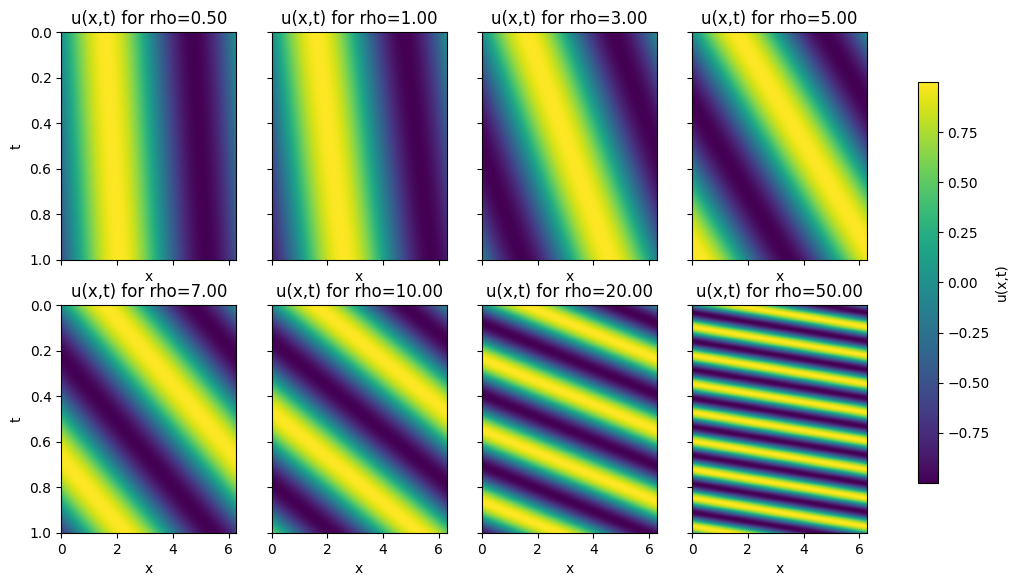

In [13]:
# Create 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(13, 6.5), sharex=True, sharey=True)

# Flatten axes array for easy looping
axes = axes.flatten()

# Store the last imshow() object for colorbar
im = None

for i, ax in enumerate(axes):
    beta = beta_values[i]
    u = convection_solution(X, T, beta)  # Compute solution for given rho
    
    im = ax.imshow(u, extent=[0, 2 * np.pi, 1, 0], aspect='auto', cmap='viridis')
    ax.set_xlabel('x')
    if i % 4 == 0:
        ax.set_ylabel('t')
    ax.set_title(f'u(x,t) for rho={beta:.2f}')

# Add a colorbar to the right of all subplots
fig.colorbar(im, ax=axes, location="right", shrink=0.8, pad=0.05, label="u(x,t)")

plt.show()

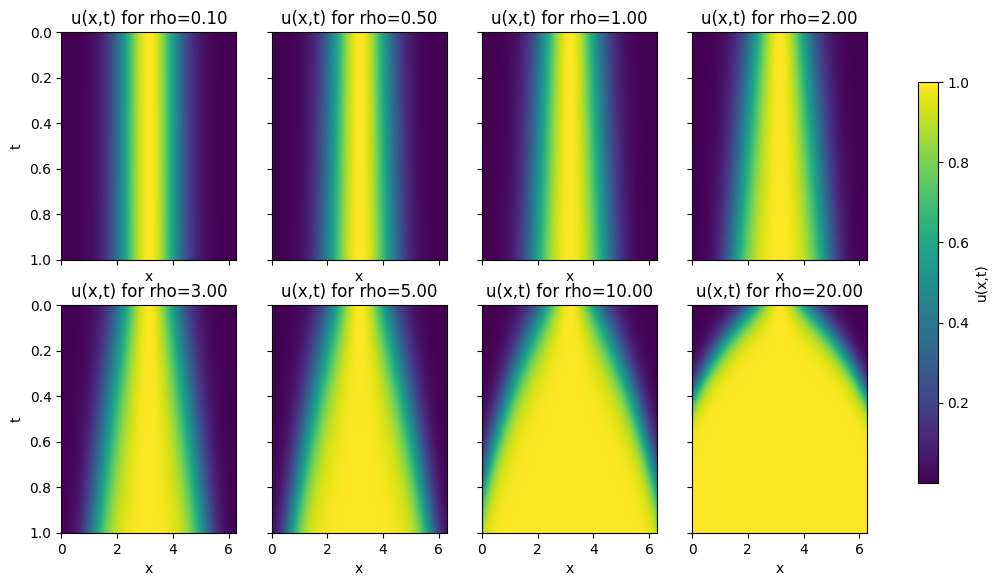

In [6]:
# Create 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(13, 6.5), sharex=True, sharey=True)

# Flatten axes array for easy looping
axes = axes.flatten()

# Store the last imshow() object for colorbar
im = None

for i, ax in enumerate(axes):
    rho = rho_values[i]
    u = reaction_solution(X, T, rho)  # Compute solution for given rho
    
    im = ax.imshow(u, extent=[0, 2 * np.pi, 1, 0], aspect='auto', cmap='viridis')
    ax.set_xlabel('x')
    if i % 4 == 0:
        ax.set_ylabel('t')
    ax.set_title(f'u(x,t) for rho={rho:.2f}')

# Add a colorbar to the right of all subplots
fig.colorbar(im, ax=axes, location="right", shrink=0.8, pad=0.05, label="u(x,t)")

plt.show()

### Regime Interpretation

- **Low ρ (< 2.0)**: Very slow reaction, almost linear in [0, 1].
- **Moderate ρ (2.0 – 10.0)**: Noticable reaction over full intervall [0,1]
- **High ρ (> 10.0)**: Fast reaction, constant after t<1

### Training Range Selection

Based on this, a **moderate ρ range (e.g., 2.0 – 10.0)** gives:
- Full reaction picture,
- Good coverage of dynamic regimes,

## !!!

Previous training range `[0.5–1.0]` covers only the **mildest part** of the regime — not representative of more dynamic or challenging regions. TODO 


We propose testing on:
- **ρ range:** `[0.5, 4.0]` !!!
- **Number of ρ values:** Start with 5–10 points (uniform), then evaluate interpolation generalization.

This setup ensures the model learns across **transient, accelerating, and stabilizing** growth patterns.

## !!!